Data File download:

https://uofc-my.sharepoint.com/:u:/g/personal/maciek_popik_ucalgary_ca/IQDr4CGfaxWDQJBmznYjCcgMAee5AfsOeKwKsajDTUTotgI?e=LbMJGO

In [1]:
import os, glob, re
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import textwrap
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


cuda:0


The first step is to import the data into the colab environment. To do this, the data was first downloaded from the TALC cluster and saved in the University of Calgary OneDrive. A shared link was made for this file (by university policy, this link must expire after 7 days of being created), uing this link the data is downloaded into colab, the files are extracted and the tar.gz archive is deleted to free up some space on the colab runtime.

In [ ]:
# === Importing and Extracting Dataset (Colab Version) ===

# # Data has been downloaded from TALC and saved on OneDrive - as per University Policy - link is only good for 1 week - current exipration: 2026-02-28
# DATA_URL = "https://uofc-my.sharepoint.com/personal/maciek_popik_ucalgary_ca/_layouts/15/download.aspx?share=IQDr4CGfaxWDQJBmznYjCcgMAXQBhIRirENb-DZUjex5Qnc"
# ARCHIVE = "garbage_data.tar.gz"
# OUTDIR = "/content/garbage_data"

# # Download & extract only if not already extracted
# if not os.path.isdir(OUTDIR):

#     print("Downloading dataset from OneDrive...")
#     !wget -q --show-progress "$DATA_URL" -O "$ARCHIVE"

#     print("\nExtracting dataset...")
#     !tar -xzf "$ARCHIVE" -C /content

#     print("Deleting archive...")
#     !rm "$ARCHIVE"

#     print("Done.")
# else:
#     print("Dataset already exists at:", OUTDIR)


# # === Define paths for training ===

# data_dir = OUTDIR
# train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
# val_dir   = os.path.join(data_dir, "CVPR_2024_dataset_Val")
# test_dir  = os.path.join(data_dir, "CVPR_2024_dataset_Test")

# print("\nTrain:", train_dir)
# print("Val:", val_dir)
# print("Test:", test_dir)


# # === Sanity check image count ===

# splits = {
#     "CVPR_2024_dataset_Train": train_dir,
#     "CVPR_2024_dataset_Val":   val_dir,
#     "CVPR_2024_dataset_Test":  test_dir,
# }

# for split_name, split_path in splits.items():
#     print(f"\n--- {split_name} ---")

#     classes = sorted([
#         d for d in os.listdir(split_path)
#         if os.path.isdir(os.path.join(split_path, d))
#     ])

#     total_images = len(glob.glob(os.path.join(split_path, "*", "*.png")))

#     print("Classes:", classes)

#     for c in classes:
#         n = len(glob.glob(os.path.join(split_path, c, "*.png")))
#         pct = (n / total_images * 100) if total_images > 0 else 0
#         print(f"{c}: {n} images - {pct:.2f}% of set")





# === Using Local Dataset (already extracted - Lab Computer Version) ===

# Root folder that already contains Train / Val / Test folders
OUTDIR = r"C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data"

if not os.path.isdir(OUTDIR):
    raise FileNotFoundError(f"Dataset folder not found: {OUTDIR}")
else:
    print("Using local dataset at:", OUTDIR)

# Define paths for training
data_dir = OUTDIR

train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir   = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir  = os.path.join(data_dir, "CVPR_2024_dataset_Test")

print("Train:", train_dir)
print("Val:", val_dir)
print("Test:", test_dir)
    
# Define paths for training
data_dir = OUTDIR
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir   = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir  = os.path.join(data_dir, "CVPR_2024_dataset_Test")

# Sanity check image count
splits = {
    "CVPR_2024_dataset_Train": train_dir,
    "CVPR_2024_dataset_Val":   val_dir,
    "CVPR_2024_dataset_Test":  test_dir,
}

for split_name, split_path in splits.items(): # Print the directory name, classes it has and number of images in each class
    print(f"\n--- {split_name} ---")
    classes = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    total_images = len(glob.glob(os.path.join(split_path, "*", "*.png"))) # Get total image count in each dir
    print("Classes:", classes)
    # Within each directory/set, print out the total number of images per class and how much % this takes up for the set
    # This will help identify imbalance of labels across the 3 sets
    for c in classes:
        n = len(glob.glob(os.path.join(split_path, c, "*.png")))
        print(f"{c}: {n} images - {n/total_images*100:.2f}% of set")

Using local dataset at: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data
Train: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data\CVPR_2024_dataset_Train
Val: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data\CVPR_2024_dataset_Val
Test: C:\Users\LA-Mahdis\Desktop\Maciek\garbage_data\CVPR_2024_dataset_Test

--- CVPR_2024_dataset_Train ---
Classes: ['Black', 'Blue', 'Green', 'TTR']
Black: 2368 images - 20.36% of set
Blue: 4842 images - 41.64% of set
Green: 2317 images - 19.92% of set
TTR: 2102 images - 18.08% of set

--- CVPR_2024_dataset_Val ---
Classes: ['Black', 'Blue', 'Green', 'TTR']
Black: 372 images - 20.67% of set
Blue: 768 images - 42.67% of set
Green: 352 images - 19.56% of set
TTR: 308 images - 17.11% of set

--- CVPR_2024_dataset_Test ---
Classes: ['Black', 'Blue', 'Green', 'TTR']
Black: 695 images - 20.25% of set
Blue: 1086 images - 31.64% of set
Green: 799 images - 23.28% of set
TTR: 852 images - 24.83% of set


Note that there is a slight imbalance of labels (Label Drift) from the evaluation set of training and validation into the testing set. The testing set contains an overall smaller percentage of Blue labels and a larger percentage of TTR labels.

Next, we define the transformations that are to be made on each dataset. Each image is 1024x1024 pixels, although in a CNN, the number of parameters does not change with larger or smaller images, the number of computations does. With 1024x1024 pixels, each with 3 channels (RGB), per image, assuming a 3x3 kernel, there are 1024x1024x3x3x3 + 1 = 28,311,553 computations per filter. To reduce the number of computations, and align closer to the size that ResNet50 was trained on (224x224 [source]), images will first be reduced in size by trial and error to determine best performance.

Additionally, several augmentations will be made including cropping the image to simulate excessive zoom, horizontal flipping to generalize against horizontal orientation, random rotations in the range of ±10° simulating instability / misorientation when a photo is taken by a user. Finally, image brightness, contrast and saturation is varied to simulate different environments in which images may have been taken.

Note that augmentations are not performed on the evaluation data (other than size for consitency) as to not alter the images used to evaluate classification performance.

In [ ]:
# === Defining Transforms Used on Data ===

# Reduced Image Size
# Stated off with 64 for lighter processing, moved up to 160, finished on 224, matching the same size of
# images that ResNet50 and MobileNet were trained on
IMG_SIZE = 224

# Below are the transforms used for the development dataset (include augmentation)
# The aim with these is to replicate the variances that might be present when someone is taking pictures
# of garbage to use such a program (ie. positional variations, vertical and horizontal flips following that
# most garbage does not really have an 'oriantation', and rotational, zoom and colour scews to replicate
# variations in the environment where such images might be taken)
transform = {
    "train": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),                    # resize to smaller specified size
        #transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),   # random crop/zoom
        transforms.RandomHorizontalFlip(p=0.5),                     # flip horizontally
        transforms.RandomVerticalFlip(p=0.2),                       # flip vertically
        transforms.RandomAffine(                                    # Random rotations, tranlations and scaling     
            degrees=15,
            translate=(0.05, 0.05),
            scale=(0.9, 1.1)
        ),
        transforms.RandomPerspective(distortion_scale=0.15, p=0.1),               # Random perspective
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),  # Variation in lighting
        transforms.ToTensor(),                                      # PIL -> torch tensor [0,1]
        transforms.Normalize(                                       # use ImageNet stats for pretrained ResNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
    ]),

    # For evaluation, we only apply the same size and stats changes that the model was trained on
    "eval": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
}


In [ ]:
# === Creation of datasets ===

# Funciton for cleaning up file names
def filename_to_text(path: str) -> str:
    name = os.path.splitext(os.path.basename(path))[0]  # remove extension and dir
    name = re.sub(r"[_\-]+", " ", name)                 # Replace _ and - with spaces
    name = re.sub(r"_\d+$", "", name)                   # remove trailing numbers
    name = re.sub(r"\s+", " ", name).strip()            # remove multiple/trailing/leading spaces
    return name

# subclass of torchvision.datasets.ImageFolder to return:
# (image, text, label) in place of: (image, label)
class ImageTextFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index) # Get image and label as normal
        path, _ = self.samples[index] # retreive path with name
        text = filename_to_text(path)  # apply above function to clean name
        return image, text, label # Return image, name, and label


# Each dataset is made using the previously defined directory and associated transform
# === Creation of datasets ===
image_datasets = {
    "train": ImageTextFolder(train_dir, transform=transform["train"]),
    "val":   ImageTextFolder(val_dir,   transform=transform["eval"]),
    "test":  ImageTextFolder(test_dir,  transform=transform["eval"])
}

# --- class weights from training set ---
# Based on the slight imbalnce of classes above, we will define class weight to penalize
# classes with less samples more than classes with more samples
train_labels = [lbl for _, lbl in image_datasets["train"].samples] # Get list of all labels
counts = np.bincount(train_labels, minlength=len(image_datasets["train"].classes)) # Count label occurances
weights = 1.0 / np.clip(counts, 1, None) # Take the inverse of the weights, clipping 0s for min value of 1
weights = weights / weights.sum() * len(weights)  # normalize weights

class_weights = torch.tensor(weights, dtype=torch.float32, device=device) # Convert numpy weight array to tensor



In [5]:
# === Creation of data loaders ===
BATCH_SIZE = 128
NUM_WORKERS = 0

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def collate_fn(batch):
    images, texts, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)

    enc = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=32,
        return_tensors="pt"
    )
    return images, enc, labels

dataLoaders = {
    "train": DataLoader(image_datasets["train"], batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn),
    "val":   DataLoader(image_datasets["val"], batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn),
    "test":  DataLoader(image_datasets["test"], batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn),
}


# Checking batch shape
images, enc, labels = next(iter(dataLoaders["train"]))

print("Batch image tensor shape:", images.shape)      # (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)
print("Batch labels shape:", labels.shape)            # (BATCH_SIZE,)
print("Batch input_ids shape:", enc["input_ids"].shape)
print("Batch attention_mask shape:", enc["attention_mask"].shape)
print("Labels example:", labels[:10].tolist())


Batch image tensor shape: torch.Size([128, 3, 160, 160])
Batch labels shape: torch.Size([128])
Batch input_ids shape: torch.Size([128, 13])
Batch attention_mask shape: torch.Size([128, 13])
Labels example: [0, 1, 1, 1, 3, 1, 1, 0, 1, 1]


In [ ]:
# === Building Model - ResNet + DistilBERT + Fusion Head ===

def make_mlp(in_dim, hidden_dims, out_dim, dropout=0.2):
    layers = []
    prev = in_dim
    for h in hidden_dims:
        layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
        prev = h
    layers += [nn.Linear(prev, out_dim)]
    return nn.Sequential(*layers)

class MultiModalNet(nn.Module):
    def __init__(self, num_classes, hidden_dims=[512, 128], dropout=0.2):
        super().__init__()

        # Vision encoder (ResNet50 -> 2048 feat)
        self.vision = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        vision_dim = self.vision.fc.in_features
        self.vision.fc = nn.Identity()

        # Text encoder (DistilBERT -> 768 feat)
        self.text = AutoModel.from_pretrained("distilbert-base-uncased")
        text_dim = 768

        # Normalize/project features before fusion
        self.vision_norm = nn.LayerNorm(vision_dim)
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.text_norm = nn.LayerNorm(512)

        # Fusion head (note: 2048 + 512 now)
        self.head = make_mlp(vision_dim + 512, hidden_dims, num_classes, dropout)

    def forward(self, images, enc):
        img_feat = self.vision(images)  # (B, 2048)

        input_ids = enc["input_ids"].to(images.device)
        attention_mask = enc["attention_mask"].to(images.device)

        txt_out = self.text(input_ids=input_ids, attention_mask=attention_mask)
        last = txt_out.last_hidden_state                       # (B, L, 768)
        mask = attention_mask.unsqueeze(-1).float()            # (B, L, 1)
        txt_feat = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)  # (B, 768)

        img_feat = self.vision_norm(img_feat)
        txt_feat = self.text_proj(txt_feat)
        txt_feat = self.text_norm(txt_feat)

        fused = torch.cat([img_feat, txt_feat], dim=1)
        return self.head(fused)

num_classes = len(image_datasets["train"].classes)
hidden_dims = [512, 256, 128]

model = MultiModalNet(num_classes=num_classes, hidden_dims=hidden_dims, dropout=0.3).to(device)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [7]:
# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Unfreeze ONLY the fusion head
for p in model.head.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=1e-2)

In [ ]:
# =========================
# CONFIG
# =========================
load_existing_weights = True

HEAD_CKPT = "./mm_head_only.pth"
FT_CKPT   = "./mm_finetuned.pth"

criterion = nn.CrossEntropyLoss(weight=class_weights)

# =========================
# HELPERS
# =========================
def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

def train_phase(model, dataLoaders, optimizer, nepochs, save_path):
    best_acc = 0.0

    best_val_loss = float("inf")
    patience = 3
    patience_ctr = 0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=1, verbose=True
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(nepochs):
        print(f"Epoch {epoch + 1}/{nepochs}")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0
            n_samples = 0

            for i, (inputs, enc, labels) in enumerate(dataLoaders[phase], 1):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs, enc)
                    loss = criterion(outputs, labels)
                    preds = outputs.argmax(dim=1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += (preds == labels).sum().item()
                n_samples += bs

                if phase == "train" and (i == 1 or i % 25 == 0):
                    print(f"epoch {epoch+1} batch {i}, current loss: {running_loss/n_samples:.4f}", flush=True)

            epoch_loss = running_loss / n_samples
            epoch_acc  = running_corrects / n_samples
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

                # step scheduler on val loss
                scheduler.step(epoch_loss)

                # early stopping on val loss
                if epoch_loss < best_val_loss - 1e-4:
                    best_val_loss = epoch_loss
                    patience_ctr = 0
                else:
                    patience_ctr += 1
                    if patience_ctr >= patience:
                        print(f"Early stopping: val loss not improving for {patience} epochs.")
                        return {
                            "train_losses": train_losses,
                            "val_losses": val_losses,
                            "train_accs": train_accs,
                            "val_accs": val_accs,
                            "best_acc": best_acc
                        }

                # save best by val accuracy (prof style)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    print("Saving best model:", save_path)
                    torch.save({
                        "model": model.state_dict(),
                        "best_acc": best_acc,
                        "train_losses": train_losses,
                        "val_losses": val_losses,
                        "train_accs": train_accs,
                        "val_accs": val_accs,
                    }, save_path)

    print(f"Best val Acc: {best_acc:.4f}")
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_acc": best_acc
    }
    return history

# =========================
# MAIN LOGIC
# =========================

# Always define hist1/hist2 so plotting works whether we TRAIN or LOAD.
# (If we load a single combined history from FT_CKPT, we’ll store it in hist1 and leave hist2 empty.)
hist1 = {"train_losses": [], "val_losses": [], "train_accs": [], "val_accs": []}
hist2 = {"train_losses": [], "val_losses": [], "train_accs": [], "val_accs": []}

# ===== If NOT training and full training was done before and weights were saved =====
if load_existing_weights and os.path.exists(FT_CKPT):
    # -------- Load fine-tuned model (preferred) --------
    ckpt = torch.load(FT_CKPT, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.to(device)
    
    # Load Phase 2 history from FT_CKPT (if present)
    c2 = torch.load(FT_CKPT, map_location="cpu")
    if "train_losses" in c2:
        hist2["train_losses"] = c2["train_losses"]
        hist2["val_losses"]   = c2["val_losses"]
        hist2["train_accs"]   = c2["train_accs"]
        hist2["val_accs"]     = c2["val_accs"]

    # Load Phase 1 history from HEAD_CKPT if it exists (so you can reconstruct full curves)
    if os.path.exists(HEAD_CKPT):
        c1 = torch.load(HEAD_CKPT, map_location="cpu")
        if "train_losses" in c1:
            hist1["train_losses"] = c1["train_losses"]
            hist1["val_losses"]   = c1["val_losses"]
            hist1["train_accs"]   = c1["train_accs"]
            hist1["val_accs"]     = c1["val_accs"]

    print("Loaded fine-tuned weights from:", FT_CKPT)

# ===== If NOT training and only fusion head weights saved =====
elif load_existing_weights and os.path.exists(HEAD_CKPT):
    # -------- Load head-only model (fallback) --------
    # This condition loads Phase 1 if finished earlier, and allows Phase 2 to complete.
    ckpt = torch.load(HEAD_CKPT, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.to(device)

    c1 = torch.load(HEAD_CKPT, map_location="cpu")
    if "train_losses" in c1:
        hist1["train_losses"] = c1["train_losses"]
        hist1["val_losses"]   = c1["val_losses"]
        hist1["train_accs"]   = c1["train_accs"]
        hist1["val_accs"]     = c1["val_accs"]

    print("Loaded head-only weights from:", HEAD_CKPT)
    # -------- Phase 2: Fine-tune specified models --------
    print("\n=== Phase 2: Fine-tune Specified Models ===")
    set_requires_grad(model.vision, True)
    set_requires_grad(model.text,   True)
    set_requires_grad(model.head,   True)

    # Smallest LR for heavy DistilBERT, slightly higher for ResNet and highest for head
    optimizer = torch.optim.AdamW([
        {"params": model.text.parameters(),   "lr": 1e-6},
        {"params": model.vision.parameters(), "lr": 1e-5},
        {"params": model.head.parameters(),   "lr": 3e-5},
    ], weight_decay=1e-2)

    # hist2 contains Phase 2 history (loss/acc curves)
    hist2 = train_phase(model, dataLoaders, optimizer, nepochs=4, save_path=FT_CKPT)

    print("\nFinished Fine-tuning")
    print("Saved fine-tuned checkpoint:", FT_CKPT)



# ===== FULL TRAINING =====
else:
    # -------- Phase 1: Train head only (freeze ResNet + DistilBERT) --------
    # Goal: quickly fit the fusion head while keeping both backbones fixed.
    print("\n=== Phase 1: Train fusion head only ===")
    set_requires_grad(model.vision, False)
    set_requires_grad(model.text,   False)
    set_requires_grad(model.head,   True)

    optimizer = torch.optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=1e-2)

    # hist1 contains Phase 1 history (loss/acc curves)
    hist1 = train_phase(model, dataLoaders, optimizer, nepochs=10, save_path=HEAD_CKPT)

    # Load best head-only weights before fine-tuning (important!)
    # Reason: train_phase saves the BEST val epoch, not necessarily the final epoch.
    ckpt = torch.load(HEAD_CKPT, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.to(device)

    # -------- Phase 2: Fine-tune ResNet + head (very low LR) --------
    # Goal: unfreeze ResNet to squeeze out extra performance, but keep LR tiny to avoid wrecking pretrained features.
    # We keep DistilBERT frozen (recommended) to reduce compute and keep training stable.
    print("\n=== Phase 2: Fine-tune Specified Models ===")
    set_requires_grad(model.vision, True)
    set_requires_grad(model.text,   True)
    set_requires_grad(model.head,   True)

    # Smallest LR for heavy DistilBERT, slightly higher for ResNet and highest for head
    optimizer = torch.optim.AdamW([
        {"params": model.text.parameters(), "lr": 1e-6},
        {"params": model.vision.parameters(), "lr": 1e-5},
        {"params": model.head.parameters(),   "lr": 3e-5},
    ], weight_decay=1e-2)

    # hist2 contains Phase 2 history (loss/acc curves)
    hist2 = train_phase(model, dataLoaders, optimizer, nepochs=4, save_path=FT_CKPT)


    print("\nFinished Training")
    print("Saved head-only checkpoint:", HEAD_CKPT)
    print("Saved fine-tuned checkpoint:", FT_CKPT)

Loaded head-only weights from: ./mm_head_only.pth

=== Phase 2: Fine-tune Specified Models ===
Epoch 1/4
epoch 1 batch 1, current loss: 0.2979
epoch 1 batch 25, current loss: 0.2382
epoch 1 batch 50, current loss: 0.2369
epoch 1 batch 75, current loss: 0.2360
train Loss: 0.2340 Acc: 0.9131
val Loss: 0.3568 Acc: 0.8800
Saving best model: ./mm_finetuned.pth
Epoch 2/4
epoch 2 batch 1, current loss: 0.1619
epoch 2 batch 25, current loss: 0.2089
epoch 2 batch 50, current loss: 0.2055
epoch 2 batch 75, current loss: 0.2062
train Loss: 0.2071 Acc: 0.9227
val Loss: 0.3518 Acc: 0.8783
Epoch 3/4
epoch 3 batch 1, current loss: 0.2411
epoch 3 batch 25, current loss: 0.1976
epoch 3 batch 50, current loss: 0.1916
epoch 3 batch 75, current loss: 0.1928
train Loss: 0.1940 Acc: 0.9258
val Loss: 0.3392 Acc: 0.8839
Saving best model: ./mm_finetuned.pth
Epoch 4/4
epoch 4 batch 1, current loss: 0.2592
epoch 4 batch 25, current loss: 0.1804
epoch 4 batch 50, current loss: 0.1794
epoch 4 batch 75, current lo

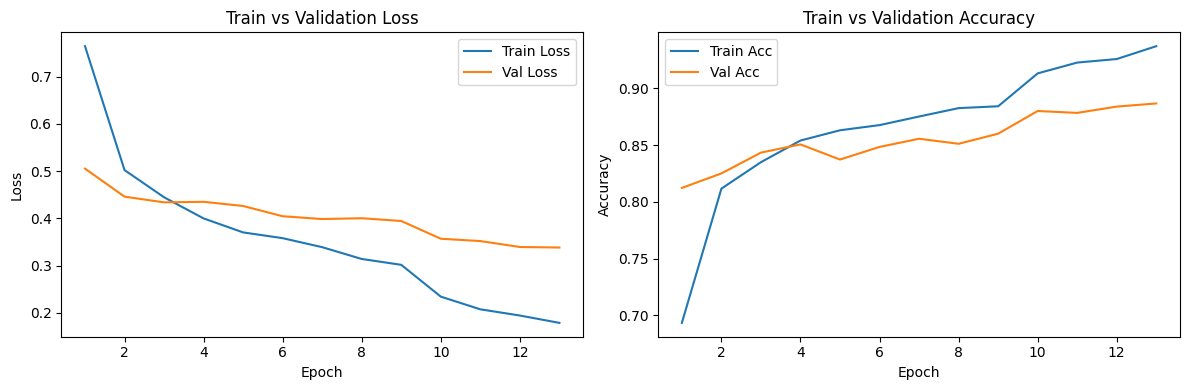

In [9]:
# === Training vs. Validation Spec Visualization ===

# Combine phase 1 and phase 2 histories
train_losses = hist1["train_losses"] + hist2["train_losses"]
val_losses   = hist1["val_losses"]   + hist2["val_losses"]
train_accs   = hist1["train_accs"]   + hist2["train_accs"]
val_accs     = hist1["val_accs"]     + hist2["val_accs"]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# --- Loss plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# --- Accuracy plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# === Testing Loop ===

# --- Helper Function for Best Model ---
def pick_best_ckpt(head_ckpt, ft_ckpt):
    best_path = None
    best_acc = -1.0

    # check head ckpt
    if os.path.exists(head_ckpt):
        c = torch.load(head_ckpt, map_location="cpu")
        acc = float(c.get("best_acc", c.get("best_val_acc", -1.0)))
        if acc > best_acc:
            best_acc = acc
            best_path = head_ckpt

    # check fine-tuned ckpt
    if os.path.exists(ft_ckpt):
        c = torch.load(ft_ckpt, map_location="cpu")
        acc = float(c.get("best_acc", c.get("best_val_acc", -1.0)))
        if acc > best_acc:
            best_acc = acc
            best_path = ft_ckpt

    if best_path is None:
        raise FileNotFoundError("No checkpoint found (neither HEAD nor FT).")

    return best_path, best_acc

# --- load best model ---
PATH, best_acc = pick_best_ckpt(HEAD_CKPT, FT_CKPT)
ckpt = torch.load(PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device)
model.eval()
print("Loaded BEST checkpoint:", PATH, "| best val acc:", best_acc)

num_classes = len(image_datasets["train"].classes)
class_names = image_datasets["train"].classes

# --- collect predictions + misclassified examples ---
y_true, y_pred = [], []
wrong = []  # (image_tensor_cpu, true_idx, pred_idx, filename)

idx_offset = 0  # tracks where we are in test_ds.samples

with torch.no_grad():
    for images, enc, labels in dataLoaders["test"]:
        batch_size = labels.size(0)

        images = images.to(device)
        labels = labels.to(device)

        # Move tokenizer outputs to GPU too
        enc = {k: v.to(device) for k, v in enc.items()}

        logits = model(images, enc)
        preds = logits.argmax(dim=1)

        # store for metrics
        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

        # safety check for filename indexing
        assert idx_offset + batch_size <= len(image_datasets["test"].samples)

        # store misclassified examples
        for k in range(batch_size):
            dataset_idx = idx_offset + k
            filepath, _ = image_datasets["test"].samples[dataset_idx]  # (path, class_idx)
            if preds[k] != labels[k]:
                wrong.append((images[k].cpu(), labels[k].item(), preds[k].item(), filepath))

        idx_offset += batch_size

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print("Test samples:", len(y_true))
print("Total misclassified:", len(wrong))

Loaded BEST checkpoint: ./mm_finetuned.pth | best val acc: 0.8866666666666667
Test samples: 3432
Total misclassified: 662


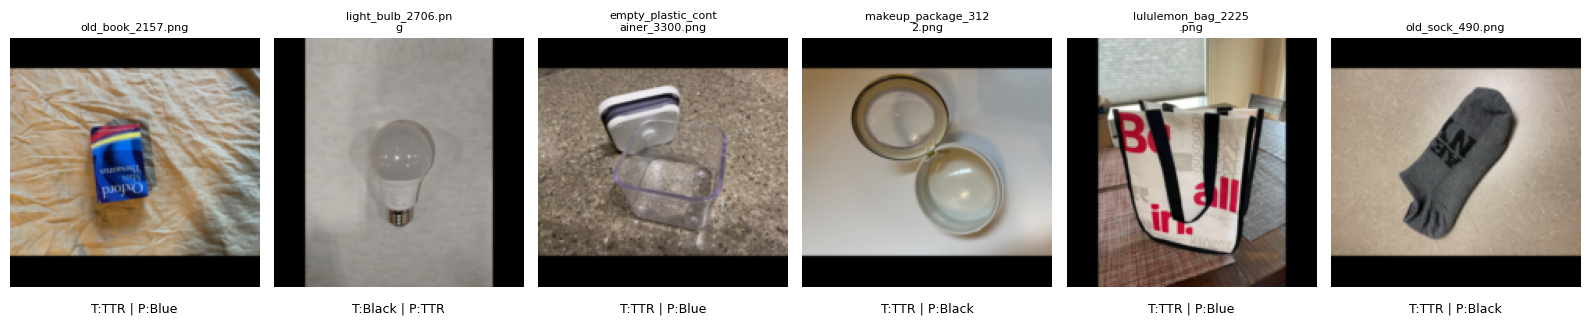

In [11]:
# === Plotting some of the mislablled samples ===

def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean

n = 6
samples = random.sample(wrong, k=min(n, len(wrong)))

plt.figure(figsize=(16, 4))
for i, (img, t, p, path) in enumerate(samples, 1):
    ax = plt.subplot(1, len(samples), i)

    ax.imshow(unnormalize(img).permute(1,2,0).clamp(0,1))
    ax.axis("off")

    fname = os.path.basename(path)
    fname = "\n".join(textwrap.wrap(fname, width=18))  # wrap long filenames

    ax.text(0.5, 1.02, fname, ha="center", va="bottom",
            transform=ax.transAxes, fontsize=8)

    ax.text(0.5, -0.06, f"T:{class_names[t]} | P:{class_names[p]}",
            ha="center", va="top", transform=ax.transAxes, fontsize=9)

plt.tight_layout()
plt.show()


In [12]:
# === Populating Confusion Matrix and Overall Model Accuracy ===
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall accuracy: {accuracy:.4f}")



Overall accuracy: 0.8071


In [13]:
# === Overall and per Class Model Stats ===
eps = 1e-12  # avoid divide-by-zero

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

sensitivity = TP / (TP + FN + eps)      # recall / TPR
specificity = TN / (TN + FP + eps)      # TNR
precision   = TP / (TP + FP + eps)
f1          = 2 * precision * sensitivity / (precision + sensitivity + eps)

print("\nPer-class metrics:")
for i, name in enumerate(class_names):
    print(f"{name:>6} | "
          f"Sens={sensitivity[i]:.3f}  "
          f"Spec={specificity[i]:.3f}  "
          f"Prec={precision[i]:.3f}  "
          f"F1={f1[i]:.3f}  "
          f"Support={cm.sum(axis=1)[i]}")

print("\nMacro averages (mean over classes):")
print(f"Sensitivity (Recall): {sensitivity.mean():.3f}")
print(f"Specificity:          {specificity.mean():.3f}")
print(f"F1:                   {f1.mean():.3f}")



Per-class metrics:
 Black | Sens=0.597  Spec=0.940  Prec=0.716  F1=0.651  Support=695
  Blue | Sens=0.895  Spec=0.866  Prec=0.755  F1=0.819  Support=1086
 Green | Sens=0.907  Spec=0.973  Prec=0.910  F1=0.909  Support=799
   TTR | Sens=0.772  Spec=0.957  Prec=0.857  F1=0.812  Support=852

Macro averages (mean over classes):
Sensitivity (Recall): 0.793
Specificity:          0.934
F1:                   0.798


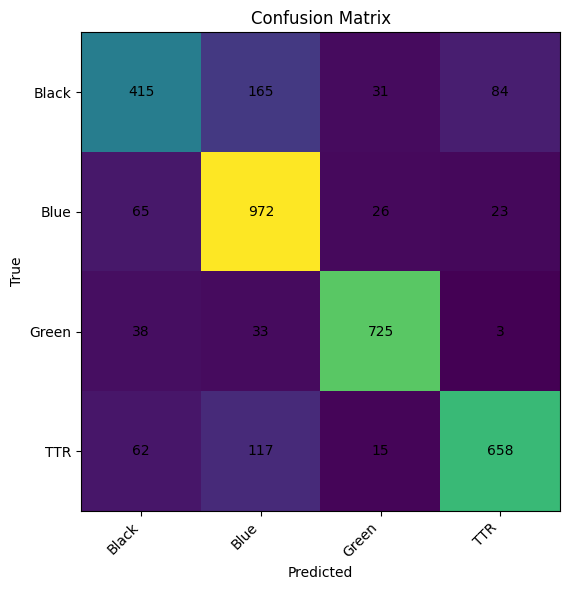

In [14]:
# === Plotting Confusion Matrix ===

plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")

# annotate counts
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [15]:
#ENEN 645 W2026 Group 4 - Assignment 2
#Team members
#Taranvir Hundal UCID: 10151486
#Mohammad Defaee UCID: 30265921
# Maciek Popik UCID: 30303637
#
#
#Equivilant raw code is stored in talc/group6_assignment2_final.py which can be run on TALC.

#1. Import Libraries and Dependencies
#The class ImageTextGarbageDataset is defined in the file image_and_text_dataset.py. It's a modified dataset that can handle both image and text data.
#The reason that class was defined in a separate file is because Jupyter Notebook does not allow increase number of workers in DataLoader if ImageTextGarbageDataset is defined in the notebook. That significantly slows down the training process.

# import torch
# import torch.nn as nn
# from torchvision import models, transforms, datasets
# import os
# from transformers import DistilBertModel, DistilBertTokenizer
# from torch.optim import AdamW, SGD
# from torch.utils.data import DataLoader
# import re
# import numpy as np
# #from image_and_text_dataset import ImageTextGarbageDataset

# #2. Define data directories.
# #Modify the path to your local or remote directory.

# data_dir = "/Users/rzhang/Desktop/talc_assignment_2"
# train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
# val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
# test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")